In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf, view_img
from bids import BIDSLayout, BIDSValidator
import nibabel as nib

def load_bids_events(layout, layout2, subject='01', run=1, tr=2.0):
    n_tr = nib.load(layout.get(subject=subject, run=run, scope='derivatives', extension='nii.gz', suffix='bold', return_type='file')[0]).shape[-1]
    
    onsets = pd.read_csv(layout2.get(subject=subject, run=run, suffix='events', return_type='file')[0], sep='\t')
    onsets = onsets[['onset','duration','trial_type']]
    onsets.columns = ['Onset', 'Duration', 'Stim']
    onsets = onsets.loc[~onsets['Stim'].isnull()]
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)


data_dir = '/home/jovyan/shared/PSYCH60-22S/fmri project data/derivatives/'
# get derivatives layout
layout = BIDSLayout(data_dir, derivatives=True)
# get non-derivatives layout
layout2 = BIDSLayout('/home/jovyan/shared/PSYCH60-22S/fmri project data')
# set parameters
subject = 'sid000920'
run = 1
# get events
onsets = load_bids_events(layout, layout2, subject=subject, run=run, tr=2.0)
onsets.info()

/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.9/site-packages/bids/layout/validation.py:129: UserWarning: Derivative indexing was requested, but no valid derivative datasets were found in the specified locations ([PosixPath('/home/jovyan/shared/PSYCH60-22S/fmri project data/derivatives/derivatives')]). Note that all BIDS-Derivatives datasets must meet all the requirements for BIDS-Raw datasets (a common problem is to fail to include a 'dataset_description.json' file in derivatives datasets).
Example contents of 'dataset_description.json':
{"Name": "Example dataset", "BIDSVersion": "1.0.2", "GeneratedBy": [{"Name": "Example pipeline"}]}
  warnings.warn("Derivative indexing was requested, b

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fam_pet_photo         225 non-null    float64
 1   fam_pet_imagine       225 non-null    float64
 2   fam_person_photo      225 non-null    float64
 3   fam_person_imagine    225 non-null    float64
 4   unfam_pet_photo       225 non-null    float64
 5   unfam_pet_imagine     225 non-null    float64
 6   unfam_person_photo    225 non-null    float64
 7   unfam_person_imagine  225 non-null    float64
dtypes: float64(8)
memory usage: 14.2 KB


/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for fam_pet_photo are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for fam_pet_imagine are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for fam_person_photo are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for fam_person_imagine are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for un

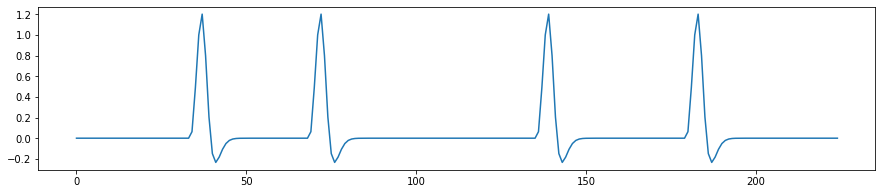

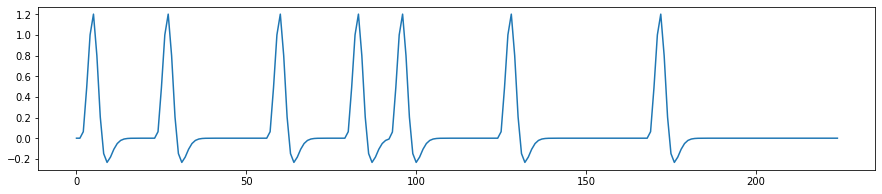

In [2]:
onsets_conv = onsets.convolve()

f,a = plt.subplots(figsize=(15,3))
onsets_conv['unfam_pet_photo_c0'].plot(ax=a)

f,a = plt.subplots(figsize=(15,3))
onsets_conv['fam_pet_photo_c0'].plot(ax=a)

dm_conv_filt = onsets_conv.add_dct_basis(duration=128)

/opt/conda/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:373: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


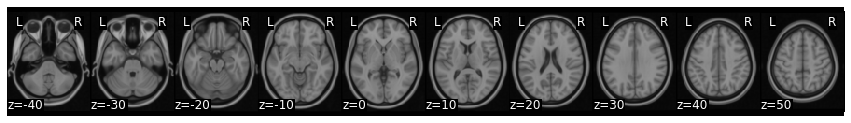

In [4]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator
import nibabel as nib


base_dir = '/home/jovyan/shared/PSYCH60-22S'

group_list = []
sub_list = ['sid000920', 'sid001085', 'sid001535', 'sid001911', 'sid002250', 'sid002257', 'sid002259']

amygdala_mask = Brain_Data('https://neurovault.org/media/images/1290/FSL_BAmyg_thr0.nii.gz')


def function(sub, run):
   
    def load_covariates(layout, subject=sub, run=run):
        return pd.read_csv(layout.get(subject=subject, run=run, scope='derivatives', extension='.tsv', suffix='regressors', return_type='file')[0], sep='\t')

    def load_brain_data(layout, subject=sub, run=run):
        return Brain_Data(layout.get(subject=subject, run=run, scope='derivatives', extension='.nii.gz', suffix='bold', return_type='file')[0], sep='\t')
    
    data = load_brain_data(layout, subject=sub, run=run)
    fwhm = 6
    smoothed = data.smooth(fwhm=fwhm)
    tr = layout.get_RepetitionTime()[0]
    n_tr = len(data)

    mask_x = expand_mask(amygdala_mask)
    amygdala = smoothed.extract_roi(mask=mask_x[0])
    
    def make_motion_covariates(mc, tr):
        z_mc = zscore(mc)
        all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
        all_mc.fillna(value=0, inplace=True)
        return Design_Matrix(all_mc, sampling_freq=1/tr)

    amygdala = zscore(pd.DataFrame(amygdala, columns=['amygdala']))

    csf_mask = Brain_Data(os.path.join(base_dir, 'masks', 'csf.nii.gz'))
    csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf']))

    spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    covariates = pd.read_csv(layout.get(subject=sub, run = run, scope='derivatives', extension='.tsv')[0].path, sep='\t')
    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc, tr)
    dm = Design_Matrix(pd.concat([amygdala, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
    dm = dm.add_poly(order=2, include_lower=True)

    smoothed.X = dm
    stats = smoothed.regress()

    amygdala_conn = stats['beta'][0]
    return amygdala_conn

for sub in sub_list:
    aggregate = (function(sub, 1) + function(sub, 2) + function(sub, 3))/3
    group_list.append(aggregate)
    
    
brain_data = Brain_Data(group_list)
t_stats = brain_data.ttest(threshold_dict={'fdr':.05})

t_stats['thr_t'].plot()    


In [ ]:
amygdala_mask = Brain_Data('https://neurovault.org/media/images/1290/FSL_BAmyg_thr0.nii.gz')
mask_x = expand_mask(amygdala_mask)

mask_x[0].plot()

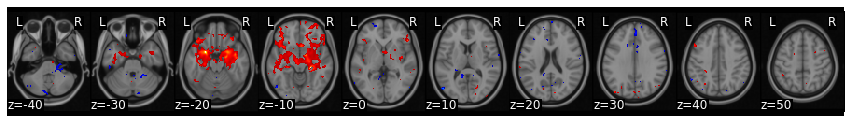

In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator
import nibabel as nib


base_dir = '/home/jovyan/shared/PSYCH60-22S'

group_list = []
sub_list = ['sid000920', 'sid001085', 'sid001535', 'sid001911', 'sid002250', 'sid002257', 'sid002259']

amygdala_mask = Brain_Data('https://neurovault.org/media/images/1290/FSL_BAmyg_thr0.nii.gz')


def function(sub, run):
   
    def load_covariates(layout, subject=sub, run=run):
        return pd.read_csv(layout.get(subject=subject, run=run, scope='derivatives', extension='.tsv', suffix='regressors', return_type='file')[0], sep='\t')

    def load_brain_data(layout, subject=sub, run=run):
        return Brain_Data(layout.get(subject=subject, run=run, scope='derivatives', extension='.nii.gz', suffix='bold', return_type='file')[0], sep='\t')
    
    data = load_brain_data(layout, subject=sub, run=run)
    fwhm = 6
    smoothed = data.smooth(fwhm=fwhm)
    tr = layout.get_RepetitionTime()[0]
    n_tr = len(data)

    mask_x = expand_mask(amygdala_mask)
    amygdala = smoothed.extract_roi(mask=mask_x[0])
    
    def make_motion_covariates(mc, tr):
        z_mc = zscore(mc)
        all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
        all_mc.fillna(value=0, inplace=True)
        return Design_Matrix(all_mc, sampling_freq=1/tr)

    amygdala = zscore(pd.DataFrame(amygdala, columns=['amygdala']))

    csf_mask = Brain_Data(os.path.join(base_dir, 'masks', 'csf.nii.gz'))
    csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf']))

    spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    covariates = pd.read_csv(layout.get(subject=sub, run = run, scope='derivatives', extension='.tsv')[0].path, sep='\t')
    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc, tr)
    dm = Design_Matrix(pd.concat([amygdala, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
    dm = dm.add_poly(order=2, include_lower=True)

    smoothed.X = dm
    stats = smoothed.regress()

    amygdala_conn = stats['beta'][0]
    return amygdala_conn

for sub in sub_list:
    aggregate = (function(sub, 1) + function(sub, 2) + function(sub, 3))/3
    group_list.append(aggregate)
    
    
brain_data = Brain_Data(group_list)
t_stats = brain_data.ttest(threshold_dict={'unc':.05})

t_stats['thr_t'].plot()   

In [3]:
t_stats['thr_t'].write(f'connectivity.nii.gz')


In [8]:
connectivity = Brain_Data('connectivity.nii.gz')


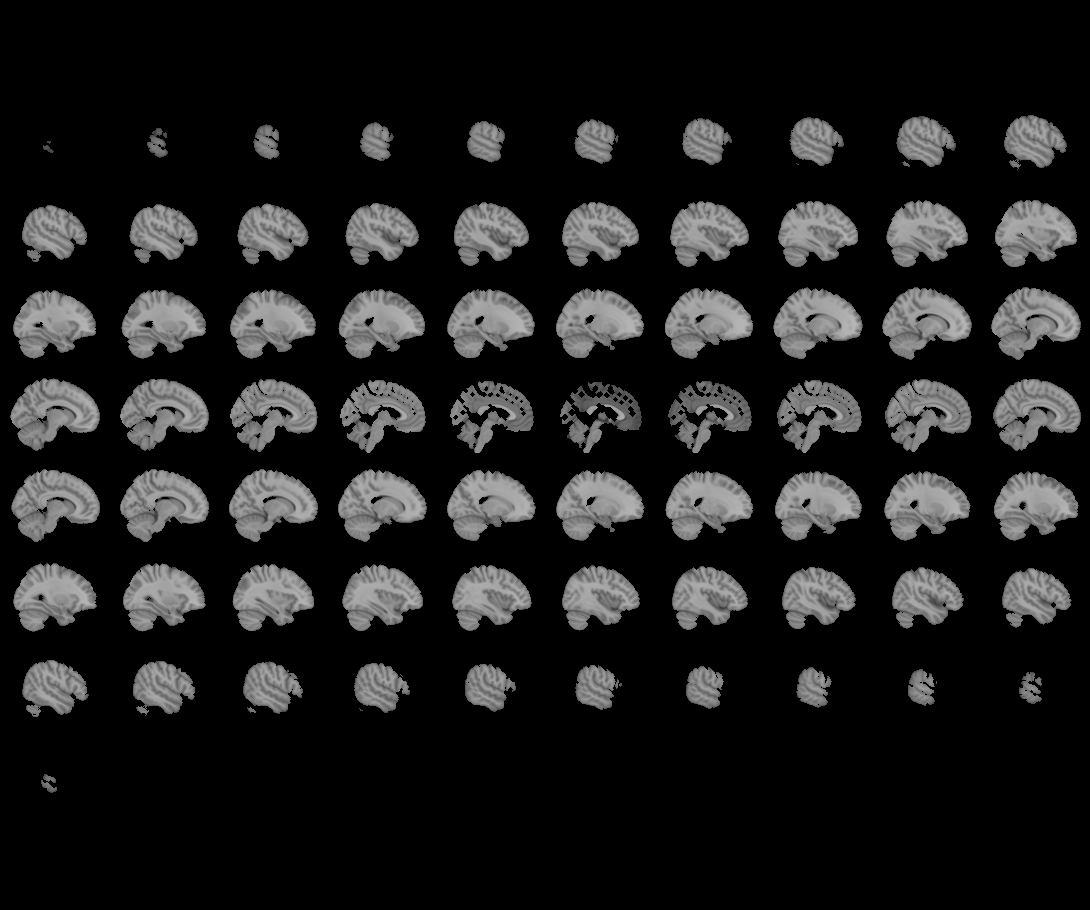
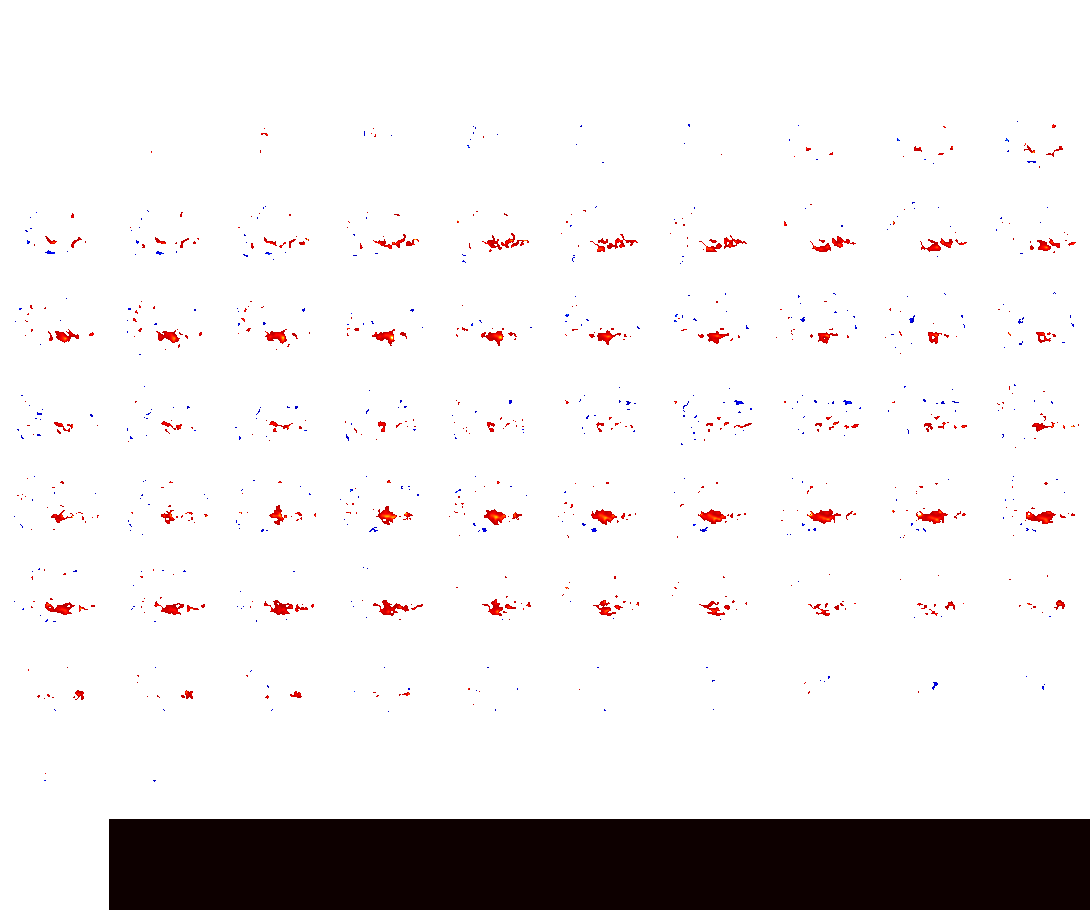

In [9]:
connectivity.iplot()


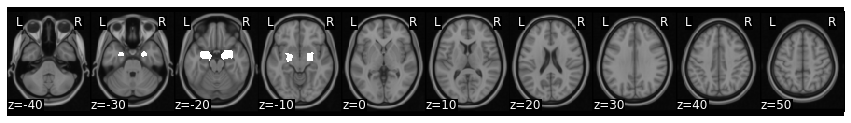